# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
import numpy

In [0]:
print (numpy.random.rand())

0.07393940574610591


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:

from pandas import DataFrame, read_csv


import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number

# Enable inline plotting
%matplotlib inline

In [4]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
Pandas version 0.24.2
Matplotlib version 3.0.3


In [0]:
# The inital set of baby names and birth rates
names = ['Bob','Jessica','Mary','John','Mel']
births = [968, 155, 77, 578, 973]

In [6]:
BabyDataSet = list(zip(names,births))
BabyDataSet

[('Bob', 968), ('Jessica', 155), ('Mary', 77), ('John', 578), ('Mel', 973)]

In [7]:
df = pd.DataFrame(data = BabyDataSet, columns=['Names', 'Births'])
df

,Names,Births
0,Bob,968
1,Jessica,155
2,Mary,77
3,John,578
4,Mel,973


In [0]:
df.to_csv('births1880.csv',index=False,header=False)

In [9]:
df.dtypes

Names     object
Births     int64
dtype: object

In [10]:
df.Births.dtype

dtype('int64')

In [11]:
# Method 1:
Sorted = df.sort_values(['Births'], ascending=False)
Sorted.head(1)

,Names,Births
4,Mel,973


In [12]:
# Method 2:
df['Births'].max()

973

The most popular name


,Names,Births
4,Mel,973


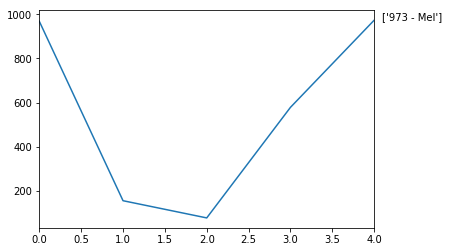

In [13]:
# Create graph
df['Births'].plot()

# Maximum value in the data set
MaxValue = df['Births'].max()

# Name associated with the maximum value
MaxName = df['Names'][df['Births'] == df['Births'].max()].values

# Text to display on graph
Text = str(MaxValue) + " - " + MaxName

# Add text to graph
plt.annotate(Text, xy=(1, MaxValue), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')

print("The most popular name")
df[df['Births'] == df['Births'].max()]
#Sorted.head(1) can also be used

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

Aim is to understand basic pandas and pyplot functions. We took 2 lists and zipped them together and converted to a dataframe on which pands functions can be applied. 
we checked the data type of each fearture ie "names" and "births" 
we sorted births in descending order. and found the max value 
another way to do same as above is to use max() function. 
next we want to represent the most common name in a graph
we find max value and the name associated with that max value. then we plot the graph and annotate the max value. 


2.  What was the most challenging part of what you did?

plotting the graph and annotating the graph with header and max value.

3.  What was the most interesting thing you learned?
how to create a data frame and do operations such as finding max value from it. 


4.  What area would you like to explore with more time?
would like to learn more about plotting graphs, i did not get this part correctly. 



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.